In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

X_mnist_train = x_train.reshape((len(x_train), 28, 28, 1))
X_mnist_test = x_test.reshape((len(x_test), 28, 28, 1))

## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [6]:
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [0]:
def generate_real_samples(dataset: np.ndarray, n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, dataset.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    random_samples = random_samples.reshape((n_samples, 28, 28, 1))
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [0]:
import matplotlib.pyplot as plt

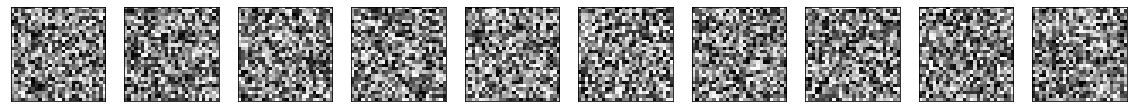

In [9]:
fake_images, _ = generate_fake_samples(10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## About the discriminator
* Since we defined the architecture of the discriminator we are going to train it sequentaly with the whole GAN, not by itself

## Defining a generator

In [0]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

In [0]:
def generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
    
    return model

In [12]:
generator = generator_model(100)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       2622

In [0]:
def generate_latent_points(latent_dim: int, n_samples: int) -> np.ndarray:
    
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [0]:
def generate_fake_generator_samples(generator: Model, latent_dim: int, n_samples: int) -> (np.ndarray, np.ndarray):
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1)) # Zeros because we want to convince the generator that these are fakes
    
    return X, y

### Initial generator examples

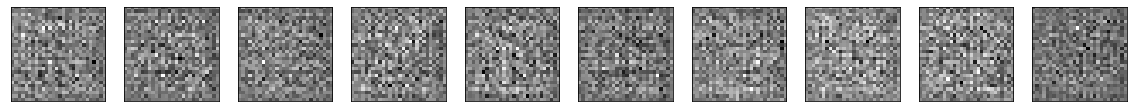

In [21]:
initial_generator_samples, _ = generate_fake_generator_samples(generator, 100, 10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(initial_generator_samples[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Defining a generator

In [0]:
from tensorflow.keras.models import Sequential

In [0]:
def define_gan(g_model: Model, d_model: Model) -> Model:
    
    d_model.trainable = False
    
    model = Sequential()
    
    model.add(g_model)
    
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [18]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 28, 28, 1)         1164289   
_________________________________________________________________
model (Model)                (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Training the GAN model

In [0]:
def test_generator(generator: Model, latent_dim: int, examples: int):
    
    generator_output = generate_fake_generator_samples(generator, latent_dim, examples)[0]
    print(generator_output.shape)
    plt.figure(figsize=(20, 20))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generator_output[i].reshape((28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [0]:
def train(g_model: Model, d_model: Model, gan_model: Model, dataset: np.ndarray, latent_dim: int, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_generator_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'{i+1}, {j+1}/{batches_per_epoch}, d={d_loss}, g={g_loss}')
        if (i + 1) % 10 == 0:
            test_generator(g_model, latent_dim, 10)

Streaming output truncated to the last 5000 lines.
6, 1002/1200, d=[0.677520215511322, 0.6171875], g=0.6535921096801758
6, 1003/1200, d=[0.6769166588783264, 0.60546875], g=0.6390873193740845
6, 1004/1200, d=[0.6902164816856384, 0.51171875], g=0.6801872253417969
6, 1005/1200, d=[0.6987036466598511, 0.5], g=0.7574853897094727
6, 1006/1200, d=[0.6845079660415649, 0.5546875], g=0.782593309879303
6, 1007/1200, d=[0.6874419450759888, 0.546875], g=0.7596884369850159
6, 1008/1200, d=[0.6884185671806335, 0.51953125], g=0.6915469169616699
6, 1009/1200, d=[0.6919683218002319, 0.5390625], g=0.6602491140365601
6, 1010/1200, d=[0.682630717754364, 0.5703125], g=0.6866247653961182
6, 1011/1200, d=[0.6801341772079468, 0.5703125], g=0.7146296501159668
6, 1012/1200, d=[0.6818311214447021, 0.59375], g=0.7313898205757141
6, 1013/1200, d=[0.688393235206604, 0.57421875], g=0.7235073447227478
6, 1014/1200, d=[0.6777307987213135, 0.55078125], g=0.695824384689331
6, 1015/1200, d=[0.6760382652282715, 0.59765625]

ValueError: ignored

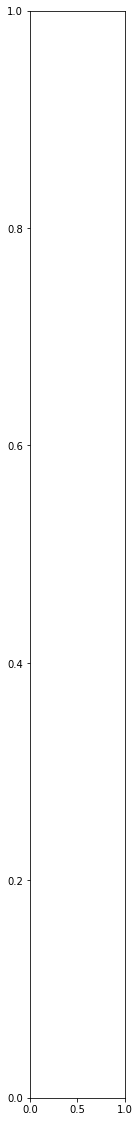

In [23]:
train(generator, discriminator, gan_model, X_mnist_train, 100, 50)

(10, 28, 28, 1)


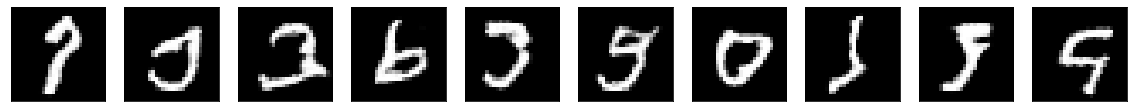

In [28]:
test_generator(generator, 100, 10)